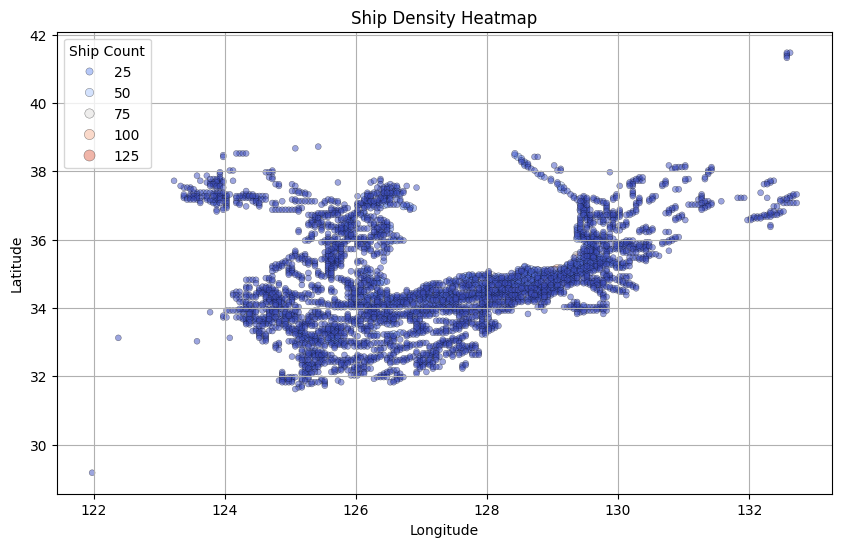

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 (예제: CSV 파일에서 로드)
file_path = "cleaned_sden_202502200100_grid3.csv"  # 파일 경로를 지정
df = pd.read_csv(file_path)

# 위도, 경도, 선박 밀집도 칼럼이 어떤 것인지 확인 후 수정
df.columns = ["Grid_ID", "Latitude", "Longitude", "Ship_Count", *df.columns[4:]]  # 앞 4개 컬럼만 활용

# 히트맵용 데이터 변환
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df["Longitude"], 
    y=df["Latitude"], 
    size=df["Ship_Count"],  # 선박 밀집도를 점 크기로 표현
    hue=df["Ship_Count"],   # 색깔로 밀집도 표현
    palette="coolwarm",
    edgecolor="black",
    alpha=0.5
)

# 제목 및 라벨 설정
plt.title("Ship Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Ship Count")
plt.grid(True)

# 히트맵 출력
plt.show()


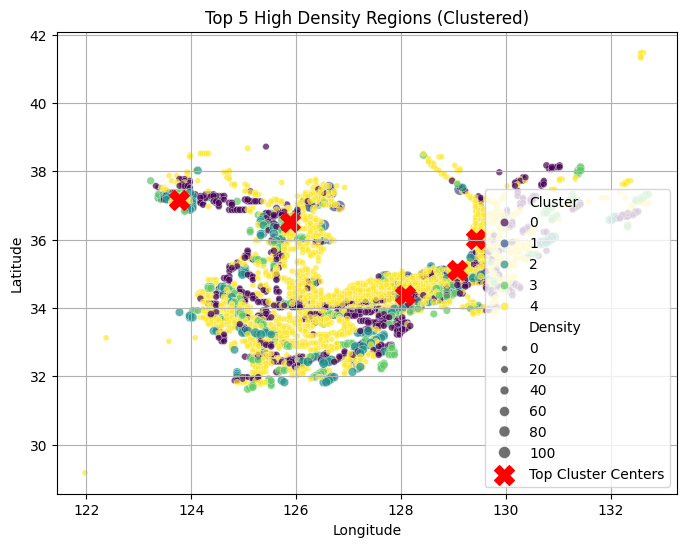

Top 5 High Density Regions (Clustered):
          Grid_ID  Latitude  Longitude  Ship_Count  Density  어선  여객선  화물선  \
353   GR3_F2N24_W    36.525    125.875           8    17.28   0    0    6   
2     GR3_G3B33_L    35.125    129.075          99   100.00   5    0   18   
43    GR3_G1N34_X    36.025    129.425          30    60.68   0    0   18   
1811  GR3_F1L44_F    37.175    123.775           2    32.12   1    0    0   
665   GR3_G3E31_L    34.375    128.075           6     6.45   0    0    1   

      유조선  예인선  수상레저기구  기타선  Cluster  
353     2    0       0    0        0  
2      42   14       0   20        1  
43      0   10       0    2        2  
1811    1    0       0    0        3  
665     2    0       0    3        4  


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
file_path = "cleaned_sden_202502200100_grid3.csv"
df = pd.read_csv(file_path, encoding="utf-8")

# KMeans 클러스터링을 위한 위도, 경도, 밀집도 데이터 사용
X = df[["Latitude", "Longitude", "Density"]]

# KMeans 적용 (클러스터 개수: 5)
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
df["Cluster"] = kmeans.fit_predict(X)

# 각 클러스터에서 가장 밀집도가 높은 중심지 찾기
top_clusters = df.loc[df.groupby("Cluster")["Density"].idxmax()]

# 클러스터 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Longitude", y="Latitude", hue=df["Cluster"], size="Density", palette="viridis", alpha=0.7)
plt.scatter(top_clusters["Longitude"], top_clusters["Latitude"], color="red", marker="X", s=200, label="Top Cluster Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Top 5 High Density Regions (Clustered)")
plt.legend()
plt.grid(True)
plt.show()

# 상위 5개 밀집 지역 출력
print("Top 5 High Density Regions (Clustered):")
print(top_clusters)


# 수치조류도 api 가시화

- **선박 밀집도가 높은 지역에서 해류가 강한 곳을 찾아 이동 가능성이 높은 지역 예측**
- **밀집도가 높고 해류 속도가 약한 곳** → **쓰레기 정체 가능성이 높은 곳**
- **밀집도가 높고 해류 속도가 빠른 곳** → **쓰레기가 해류 방향으로 이동 가능성이 높은 곳**

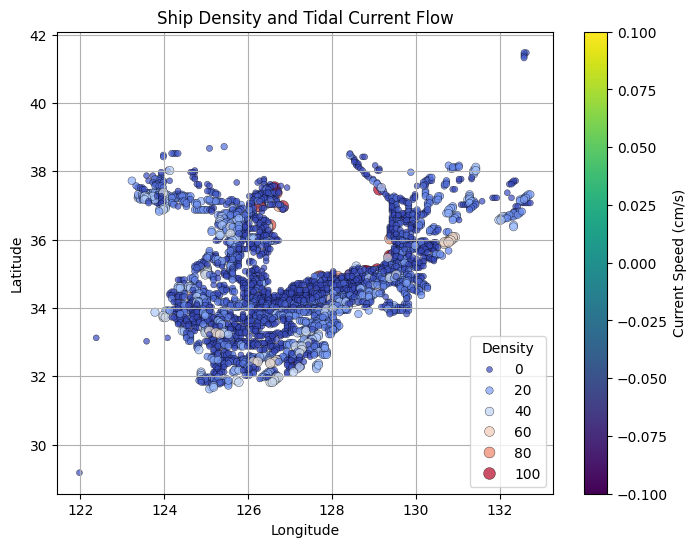

       Grid_ID  Latitude  Longitude  Ship_Count  Density  어선  여객선  화물선  유조선  \
0  GR3_G3B32_D    35.475    129.425         147    50.48  76    0    2   23   
1  GR3_G3B33_P    35.075    129.025         106    46.12  44    1   10   11   
2  GR3_G3B33_L    35.125    129.075          99   100.00   5    0   18   42   
3  GR3_F4H23_E    34.725    127.725          95    32.83  45    2    4    3   
4  GR3_G3E12_S    34.825    128.425          86    11.93  64    5    1    0   

   예인선  수상레저기구  기타선  current_dir  current_speed  
0    0       1   45          NaN            NaN  
1   14       2   24          NaN            NaN  
2   14       0   20          NaN            NaN  
3    1       0   40          NaN            NaN  
4    0       1   15          NaN            NaN  


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 1. KHOA API에서 수치 조류도 데이터 가져오기
def fetch_tidal_current_data(service_key, date, hour, minute, min_x, max_x, min_y, max_y):
    """
    KHOA 해양수산부 API를 호출하여 수치 조류도 데이터를 가져오는 함수
    :param service_key: API 인증키
    :param date: 검색 날짜 (YYYYMMDD)
    :param hour: 검색 시간 (HH)
    :param minute: 검색 시간 (MM)
    :param min_x, max_x: 검색 영역 (최소, 최대 경도)
    :param min_y, max_y: 검색 영역 (최소, 최대 위도)
    :return: Pandas DataFrame
    """
    base_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    
    params = {
        "ServiceKey": service_key,
        "Date": date,
        "Hour": hour,
        "Minute": minute,
        "MaxX": max_x,
        "MinX": min_x,
        "MaxY": max_y,
        "MinY": min_y,
        "ResultType": "json"
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]

        # JSON → Pandas DataFrame 변환
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)

        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)

        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None


# ✅ 2. 선박 밀집도 데이터 불러오기
def load_ship_density_data(file_path):
    """
    로컬에 저장된 선박 밀집도 데이터를 불러오는 함수
    :param file_path: CSV 파일 경로
    :return: Pandas DataFrame
    """
    df_ship = pd.read_csv(file_path, encoding="utf-8")
    return df_ship


# ✅ 3. 선박 밀집도와 조류 데이터를 매칭
def merge_data(df_ship, df_tidal):
    """
    선박 밀집도 데이터와 조류 데이터를 위경도를 기준으로 매칭
    :param df_ship: 선박 밀집도 데이터
    :param df_tidal: 조류 데이터
    :return: 결합된 DataFrame
    """
    df_combined = pd.merge(df_ship, df_tidal, on=["Latitude", "Longitude"], how="left")
    return df_combined


# ✅ 4. 데이터 시각화 (히트맵 + 조류 흐름)
def plot_data(df_combined):
    """
    선박 밀집도 히트맵과 조류 흐름 벡터를 시각화
    :param df_combined: 선박 밀집도 + 조류 데이터 결합된 DataFrame
    """
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_combined, x="Longitude", y="Latitude", size="Density", hue="Density", 
                    palette="coolwarm", edgecolor="black", alpha=0.7)

    plt.quiver(df_combined["Longitude"], df_combined["Latitude"], 
               np.cos(np.radians(df_combined["current_dir"])), 
               np.sin(np.radians(df_combined["current_dir"])), 
               df_combined["current_speed"], cmap="viridis", scale=500, width=0.005)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Ship Density and Tidal Current Flow")
    plt.colorbar(label="Current Speed (cm/s)")
    plt.grid(True)
    plt.show()


# ✅ 5. 실행 부분
if __name__ == "__main__":
    # 📌 KHOA API 요청 정보 설정 (네가 사용하는 API에 맞게 수정)
    SERVICE_KEY = "c/JboSuOOn1VCop00VUC1w=="  # API 인증키
    DATE = "20250220"  # YYYYMMDD 형식 (예: 2025년 2월 20일)
    HOUR = "01"  # HH 형식 (24시간제, 예: 15시)
    MINUTE = "00"  # MM 형식 (예: 00분)
    MIN_X, MAX_X = "122", "133"  # 검색 영역 (최소, 최대 경도)
    MIN_Y, MAX_Y = "31", "39"  # 검색 영역 (최소, 최대 위도)

    # 📌 1. API 데이터 가져오기
    df_tidal = fetch_tidal_current_data(SERVICE_KEY, DATE, HOUR, MINUTE, MIN_X, MAX_X, MIN_Y, MAX_Y)

    if df_tidal is not None:
        # 📌 2. 선박 밀집도 데이터 불러오기 (파일 경로 수정)
        SHIP_DENSITY_FILE = "cleaned_sden_202502200100_grid3.csv"
        df_ship = load_ship_density_data(SHIP_DENSITY_FILE)

        # 📌 3. 데이터 결합
        df_combined = merge_data(df_ship, df_tidal)

        # 📌 4. 시각화
        plot_data(df_combined)

        # 📌 5. 결과 데이터 출력
        print(df_combined.head())
    else:
        print("API 데이터를 가져오지 못했습니다. 확인해주세요.")


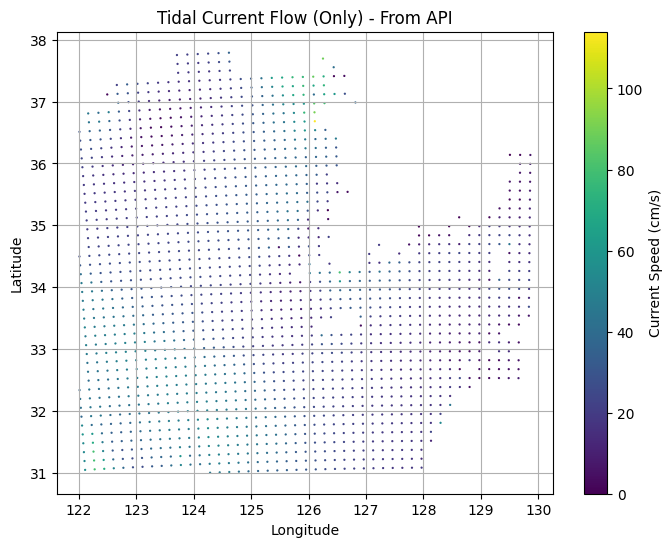

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ KHOA API에서 수치 조류도 데이터 가져오기
def fetch_tidal_current_data(service_key, date, hour, minute, min_x, max_x, min_y, max_y):
    """
    KHOA 해양수산부 API를 호출하여 수치 조류도 데이터를 가져오는 함수
    :param service_key: API 인증키
    :param date: 검색 날짜 (YYYYMMDD)
    :param hour: 검색 시간 (HH)
    :param minute: 검색 시간 (MM)
    :param min_x, max_x: 검색 영역 (최소, 최대 경도)
    :param min_y, max_y: 검색 영역 (최소, 최대 위도)
    :return: Pandas DataFrame
    """
    base_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    
    params = {
        "ServiceKey": service_key,
        "Date": date,
        "Hour": hour,
        "Minute": minute,
        "MaxX": max_x,
        "MinX": min_x,
        "MaxY": max_y,
        "MinY": min_y,
        "ResultType": "json"
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]

        # JSON → Pandas DataFrame 변환
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)

        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)

        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None

# ✅ 해류 흐름만 따로 그래프 생성
def plot_tidal_data(df_tidal):
    """
    해류 데이터만 시각화하는 함수 (벡터 플롯)
    :param df_tidal: 해류 데이터
    """
    plt.figure(figsize=(8,6))

    # 해류 흐름 벡터 플롯 (Quiver Plot)
    plt.quiver(df_tidal["Longitude"], df_tidal["Latitude"], 
               np.cos(np.radians(df_tidal["current_dir"])), 
               np.sin(np.radians(df_tidal["current_dir"])), 
               df_tidal["current_speed"], cmap="viridis", scale=500, width=0.005)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tidal Current Flow (Only) - From API")
    plt.colorbar(label="Current Speed (cm/s)")
    plt.grid(True)

    # 그래프 출력
    plt.show()

# ✅ 실행 부분
if __name__ == "__main__":
    # 📌 KHOA API 요청 정보 설정 (네가 사용하는 API에 맞게 수정)
    SERVICE_KEY = "c/JboSuOOn1VCop00VUC1w=="  # API 인증키
    DATE = "20250220"  # YYYYMMDD 형식
    HOUR = "01"  # HH 형식 (24시간제)
    MINUTE = "00"  # MM 형식
    MIN_X, MAX_X = "122", "133"  # 검색 영역 (최소, 최대 경도)
    MIN_Y, MAX_Y = "31", "39"  # 검색 영역 (최소, 최대 위도)

    # 📌 1. API 데이터 가져오기
    df_tidal = fetch_tidal_current_data(SERVICE_KEY, DATE, HOUR, MINUTE, MIN_X, MAX_X, MIN_Y, MAX_Y)

    if df_tidal is not None:
        # 📌 2. 해류 데이터 시각화
        plot_tidal_data(df_tidal)
    else:
        print("API 데이터를 가져오지 못했습니다. 확인해주세요.")


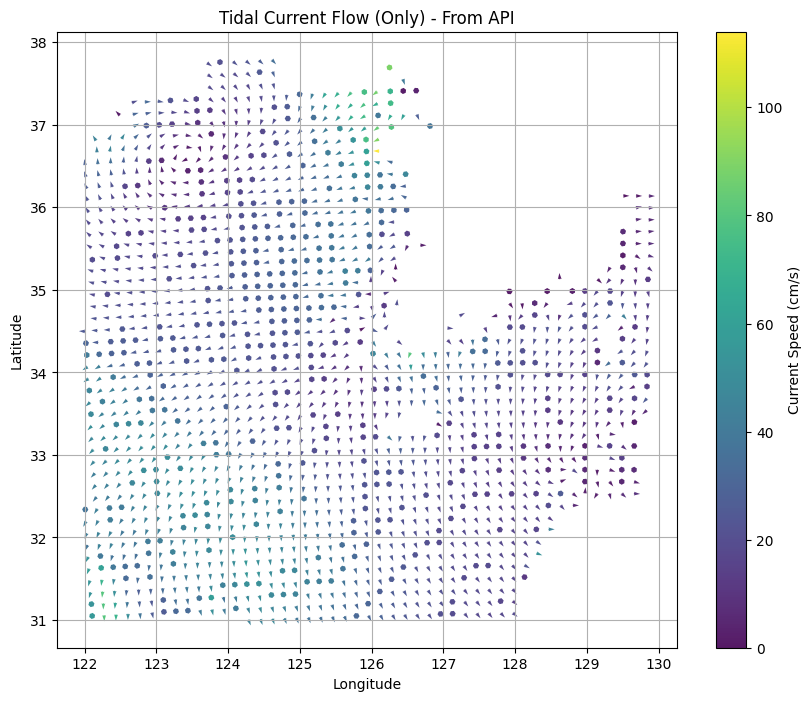

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ KHOA API에서 수치 조류도 데이터 가져오기
def fetch_tidal_current_data(service_key, date, hour, minute, min_x, max_x, min_y, max_y):
    """
    KHOA 해양수산부 API를 호출하여 수치 조류도 데이터를 가져오는 함수
    :param service_key: API 인증키
    :param date: 검색 날짜 (YYYYMMDD)
    :param hour: 검색 시간 (HH)
    :param minute: 검색 시간 (MM)
    :param min_x, max_x: 검색 영역 (최소, 최대 경도)
    :param min_y, max_y: 검색 영역 (최소, 최대 위도)
    :return: Pandas DataFrame
    """
    base_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    
    params = {
        "ServiceKey": service_key,
        "Date": date,
        "Hour": hour,
        "Minute": minute,
        "MaxX": max_x,
        "MinX": min_x,
        "MaxY": max_y,
        "MinY": min_y,
        "ResultType": "json"
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]

        # JSON → Pandas DataFrame 변환
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)

        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)

        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None

# ✅ 해류 흐름만 따로 그래프 생성
def plot_tidal_data(df_tidal):
    """
    해류 데이터만 시각화하는 함수 (벡터 플롯)
    :param df_tidal: 해류 데이터
    """
    plt.figure(figsize=(10,8))

    # 해류 흐름 벡터 플롯 (Quiver Plot)
    plt.quiver(df_tidal["Longitude"], df_tidal["Latitude"], 
               np.cos(np.radians(df_tidal["current_dir"])), 
               np.sin(np.radians(df_tidal["current_dir"])), 
               df_tidal["current_speed"], cmap="viridis", scale=100, width=0.01, alpha=0.9)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tidal Current Flow (Only) - From API")
    plt.colorbar(label="Current Speed (cm/s)")
    plt.grid(True)

    # 그래프 출력
    plt.show()

# ✅ 실행 부분
if __name__ == "__main__":
    # 📌 KHOA API 요청 정보 설정 (네가 사용하는 API에 맞게 수정)
    SERVICE_KEY = "c/JboSuOOn1VCop00VUC1w=="  # API 인증키
    DATE = "20250220"  # YYYYMMDD 형식
    HOUR = "01"  # HH 형식 (24시간제)
    MINUTE = "00"  # MM 형식
    MIN_X, MAX_X = "122", "133"  # 검색 영역 (최소, 최대 경도)
    MIN_Y, MAX_Y = "31", "39"  # 검색 영역 (최소, 최대 위도)

    # 📌 1. API 데이터 가져오기
    df_tidal = fetch_tidal_current_data(SERVICE_KEY, DATE, HOUR, MINUTE, MIN_X, MAX_X, MIN_Y, MAX_Y)

    if df_tidal is not None:
        # 📌 2. 해류 데이터 시각화
        plot_tidal_data(df_tidal)
    else:
        print("API 데이터를 가져오지 못했습니다. 확인해주세요.")


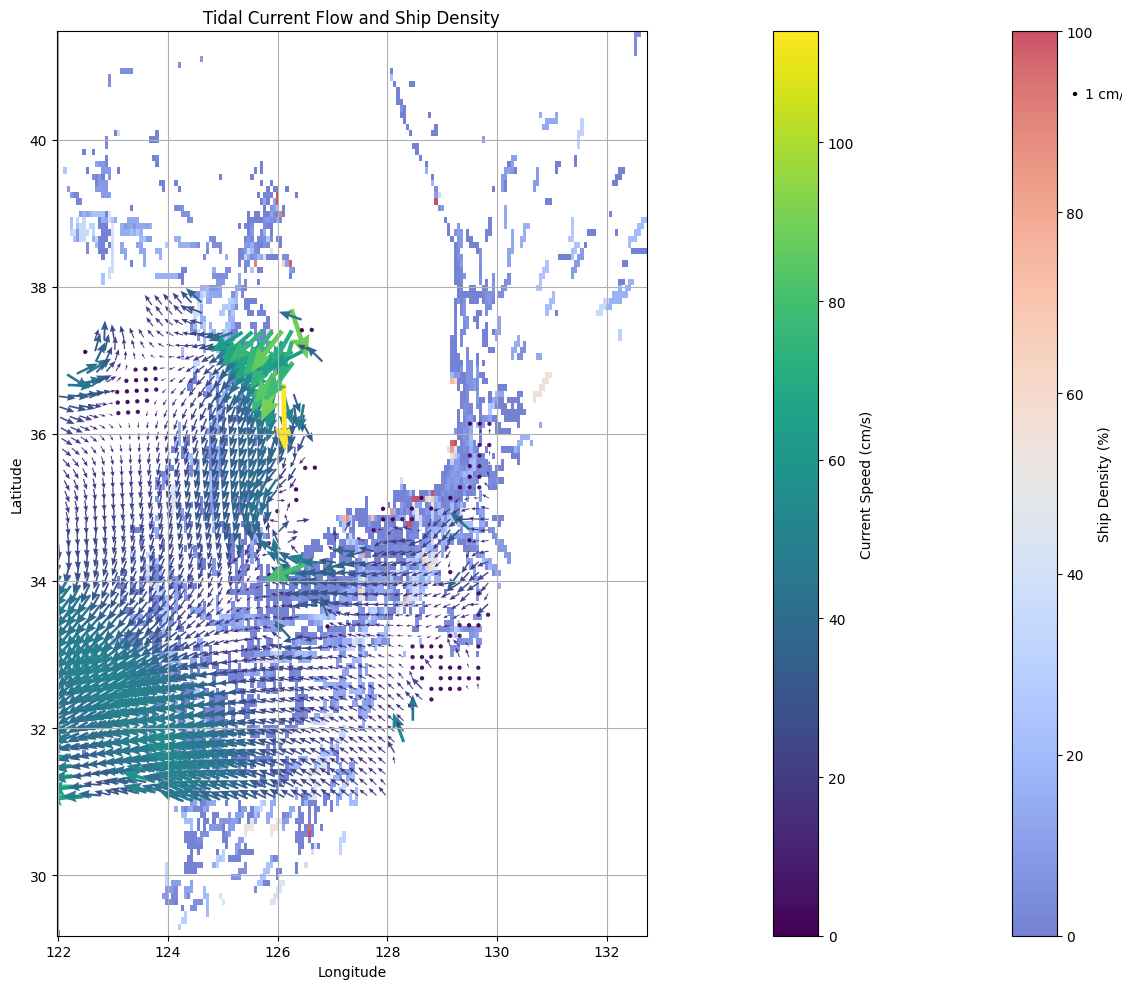

In [16]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ KHOA API에서 수치 조류도 데이터 가져오기
def fetch_tidal_current_data(service_key, date, hour, minute, min_x, max_x, min_y, max_y):
    base_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    
    params = {
        "ServiceKey": service_key,
        "Date": date,
        "Hour": hour,
        "Minute": minute,
        "MaxX": max_x,
        "MinX": min_x,
        "MaxY": max_y,
        "MinY": min_y,
        "ResultType": "json"
    }

    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]

        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)
        
        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)

        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None


# ✅ 선박 밀집도 데이터 불러오기
def load_ship_density_data(file_path):
    """
    선박 밀집도 데이터를 불러오는 함수
    :param file_path: CSV 파일 경로
    :return: Pandas DataFrame
    """
    df_ship = pd.read_csv(file_path, encoding="utf-8")
    df_ship["Latitude"] = df_ship["Latitude"].astype(float)
    df_ship["Longitude"] = df_ship["Longitude"].astype(float)
    return df_ship


# ✅ 해류 흐름 + 선박 밀집도 시각화
def plot_tidal_and_ship_density(df_tidal, df_ship):
   fig, ax = plt.subplots(figsize=(12, 10))
   
   # 1. 전체 시각화 영역 설정
   min_lon = min(df_tidal['Longitude'].min(), df_ship['Longitude'].min())
   max_lon = max(df_tidal['Longitude'].max(), df_ship['Longitude'].max())
   min_lat = min(df_tidal['Latitude'].min(), df_ship['Latitude'].min())
   max_lat = max(df_tidal['Latitude'].max(), df_ship['Latitude'].max())
   
   ax.set_xlim(min_lon, max_lon)
   ax.set_ylim(min_lat, max_lat)

   # 2. 선박 밀집도 시각화
   density_map = df_ship.pivot_table(
       index='Latitude', 
       columns='Longitude', 
       values='Density', 
       aggfunc='mean'
   )
   
   extent = [
       density_map.columns.min(),
       density_map.columns.max(),
       density_map.index.min(),
       density_map.index.max()
   ]
   
   im1 = ax.imshow(
       density_map,
       aspect='auto',
       extent=extent,
       origin='lower',
       cmap='coolwarm',
       alpha=0.7
   )
   
   # 3. 해류 흐름 벡터 플롯
   # 방향 각도를 라디안으로 변환
   angles = np.radians(90 - df_tidal["current_dir"])  # 북쪽을 0도로 설정
   
   # U, V 성분 계산
   U = df_tidal["current_speed"] * np.cos(angles)
   V = df_tidal["current_speed"] * np.sin(angles)
   
   im2 = ax.quiver(
       df_tidal["Longitude"],
       df_tidal["Latitude"],
       U, V,  # 수정된 벡터 성분
       df_tidal["current_speed"],
       cmap="viridis",
       scale=1000,
       width=0.008,
       headwidth=4,
       headlength=5,
       headaxislength=4.5,
       minshaft=2
   )

   # 참조 화살표 추가
   qk = ax.quiverkey(im2, 0.9, 0.9, 1, '1 cm/s',
                     labelpos='E',
                     coordinates='figure')

   # 4. 컬러바 추가
   cbar1 = fig.colorbar(im1, ax=ax, location='right', pad=0.1, label="Ship Density (%)")
   
   sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=df_tidal["current_speed"].min(), 
                                                                 vmax=df_tidal["current_speed"].max()))
   sm.set_array([])
   cbar2 = fig.colorbar(sm, ax=ax, location='right', pad=0.15, label="Current Speed (cm/s)")

   ax.set_xlabel("Longitude")
   ax.set_ylabel("Latitude")
   ax.set_title("Tidal Current Flow and Ship Density")
   ax.grid(True)
   
   plt.tight_layout()
   plt.show()


# ✅ 실행 부분
if __name__ == "__main__":
    # 📌 KHOA API 요청 정보 설정 (네가 사용하는 API에 맞게 수정)
    SERVICE_KEY = "c/JboSuOOn1VCop00VUC1w=="  # API 인증키
    DATE = "20250220"  # YYYYMMDD 형식
    HOUR = "01"  # HH 형식 (24시간제)
    MINUTE = "00"  # MM 형식
    MIN_X, MAX_X = "122", "133"  # 검색 영역 (최소, 최대 경도)
    MIN_Y, MAX_Y = "31", "39"  # 검색 영역 (최소, 최대 위도)

    # 📌 1. 해류 데이터 가져오기
    df_tidal = fetch_tidal_current_data(SERVICE_KEY, DATE, HOUR, MINUTE, MIN_X, MAX_X, MIN_Y, MAX_Y)

    # 📌 2. 선박 밀집도 데이터 로드
    SHIP_DENSITY_FILE = "cleaned_sden_202502200100_grid3.csv"
    df_ship = load_ship_density_data(SHIP_DENSITY_FILE)

    if df_tidal is not None:
        # 📌 3. 해류와 선박 밀집도 시각화
        plot_tidal_and_ship_density(df_tidal, df_ship)
    else:
        print("API 데이터를 가져오지 못했습니다. 확인해주세요.")


# 단순한 가정

해양쓰레기 수거선의 최적 경로를 추정하는 인공지능 모델을 만들고 싶다.
전국을 아우르는 격자별 해양쓰레기 실시간 배출량을 알 수가 없어서 실시간 격자별 선박 밀집도로 대신할 것이다.
선박밀집도가 높을 수록 쓰레기배출이 높다는 연구결과가 있어서 근거가 있다고 생각한다.
그리고 실시간 수치조류도를 이용할거다. (실시간 해류의 방향과 속도를 위경도별로 예측한 모델자료)
그러면 위치(격자별)로 선박의 밀집도와 해류의 방향, 세기가 결정이 된다.

선박밀집도와 쓰레기배출량이 비례한다고 가정하면
해류에 의해 쓰레기가 이동한다고 추론할 수 있다. 어떻게 이동하는지는 아직 정하지 않아서... 모델이 필요하거나 계산이 필요하다.

쓰레기 배출량이 선박밀집도에 비례하고, 해류 데이터가 있을 때 해류데이터에 의해 시간당 쓰레기 배출량이 이동한 지도는 어떻게 나타나게 될까?
-> 쓰레기의 이동 코드
## 쓰레기의 이동

In [17]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def create_uniform_grid(df_ship, df_tidal, grid_size=100):
    """균일한 격자 생성"""
    # 전체 영역 범위 설정
    lon_min = min(df_ship['Longitude'].min(), df_tidal['Longitude'].min())
    lon_max = max(df_ship['Longitude'].max(), df_tidal['Longitude'].max())
    lat_min = min(df_ship['Latitude'].min(), df_tidal['Latitude'].min())
    lat_max = max(df_ship['Latitude'].max(), df_tidal['Latitude'].max())
    
    # 균일한 격자점 생성
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    
    return lon_mesh, lat_mesh

def interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh):
    """데이터 보간"""
    # 선박 밀집도 보간
    density = griddata(
        (df_ship['Longitude'], df_ship['Latitude']),
        df_ship['Density'],
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    # 해류 U, V 성분 보간
    angles = np.radians(90 - df_tidal["current_dir"])
    U = df_tidal["current_speed"] * np.cos(angles)
    V = df_tidal["current_speed"] * np.sin(angles)
    
    U_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        U,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    V_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        V,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    return density, U_interp, V_interp

def simulate_waste_movement(density, U_interp, V_interp, dt=1, steps=24):
    """쓰레기 이동 시뮬레이션"""
    waste = density.copy()  # 초기 쓰레기 분포는 선박 밀집도와 비례
    waste_history = [waste.copy()]
    
    for _ in range(steps):
        # 이류 항(advection term) 계산
        waste_new = waste.copy()
        
        # 중앙 차분법을 사용한 이류 계산
        dx = 1.0  # 격자 간격 (실제 거리로 조정 필요)
        dy = 1.0
        
        # x 방향 이류
        waste_new[1:-1, 1:-1] -= (
            (U_interp[1:-1, 1:-1] * 
             (waste[1:-1, 2:] - waste[1:-1, :-2]) / (2 * dx)) * dt
        )
        
        # y 방향 이류
        waste_new[1:-1, 1:-1] -= (
            (V_interp[1:-1, 1:-1] * 
             (waste[2:, 1:-1] - waste[:-2, 1:-1]) / (2 * dy)) * dt
        )
        
        # 확산 항 추가 (단순화된 확산)
        diffusion_coef = 0.1
        waste_new[1:-1, 1:-1] += diffusion_coef * (
            (waste[2:, 1:-1] + waste[:-2, 1:-1] + 
             waste[1:-1, 2:] + waste[1:-1, :-2] - 
             4 * waste[1:-1, 1:-1]) / (dx * dy)
        ) * dt
        
        # 경계 조건 처리
        waste_new[waste_new < 0] = 0
        
        waste = waste_new
        waste_history.append(waste.copy())
    
    return waste_history

def plot_waste_movement(lon_mesh, lat_mesh, waste_history, time_steps=[0, 6, 12, 23]):
    """시간별 쓰레기 분포 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, step in enumerate(time_steps):
        im = axes[idx].pcolormesh(
            lon_mesh, lat_mesh, waste_history[step],
            shading='auto',
            cmap='YlOrRd'
        )
        axes[idx].set_title(f'Time step: {step} hours')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        fig.colorbar(im, ax=axes[idx], label='Waste Density')
    
    plt.tight_layout()
    plt.show()

# 메인 실행 함수
def run_waste_simulation(df_ship, df_tidal):
    # 1. 균일한 격자 생성
    lon_mesh, lat_mesh = create_uniform_grid(df_ship, df_tidal)
    
    # 2. 데이터 보간
    density, U_interp, V_interp = interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh)
    
    # 3. 쓰레기 이동 시뮬레이션
    waste_history = simulate_waste_movement(density, U_interp, V_interp)
    
    # 4. 결과 시각화
    plot_waste_movement(lon_mesh, lat_mesh, waste_history)
    
    return waste_history

## 20250220 01시 쓰레기의 이동 가시화

c:\Users\TAN\.conda\envs\marideb\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\TAN\.conda\envs\marideb\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


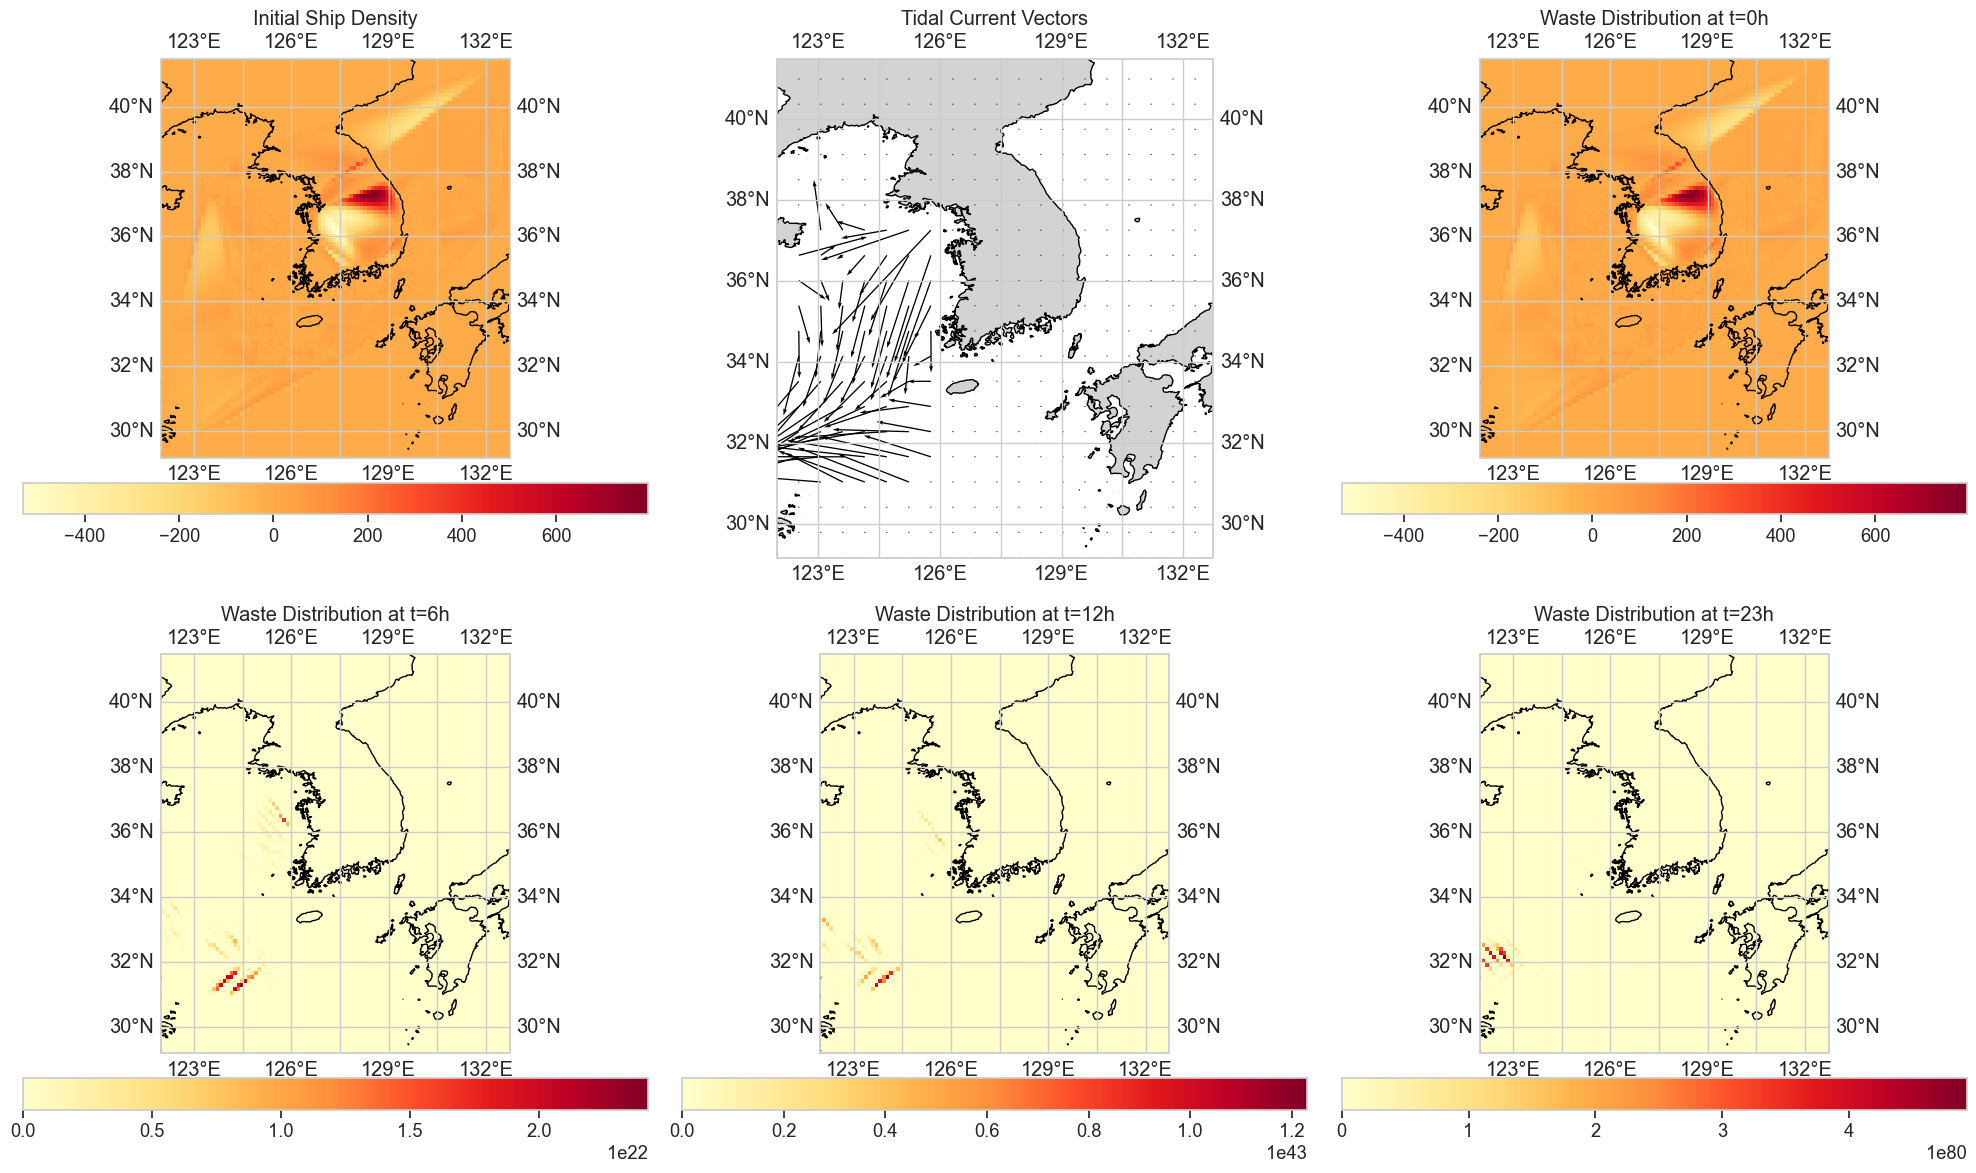

<Figure size 640x480 with 0 Axes>

In [21]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Seaborn 스타일 설정
sns.set_style("whitegrid")

def fetch_tidal_current_data(api_url):
    """KHOA API에서 조류 데이터 가져오기"""
    response = requests.get(api_url)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]
        
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)
        
        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)
        
        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None

def load_ship_density_data(file_path):
    """선박 밀집도 데이터 로드"""
    df_ship = pd.read_csv(file_path, encoding="utf-8")
    df_ship["Latitude"] = df_ship["Latitude"].astype(float)
    df_ship["Longitude"] = df_ship["Longitude"].astype(float)
    return df_ship

def create_uniform_grid(df_ship, df_tidal, grid_size=100):
    """균일한 격자 생성"""
    lon_min = min(df_ship['Longitude'].min(), df_tidal['Longitude'].min())
    lon_max = max(df_ship['Longitude'].max(), df_tidal['Longitude'].max())
    lat_min = min(df_ship['Latitude'].min(), df_tidal['Latitude'].min())
    lat_max = max(df_ship['Latitude'].max(), df_tidal['Latitude'].max())
    
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    
    return lon_mesh, lat_mesh

def interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh):
    """데이터 보간"""
    density = griddata(
        (df_ship['Longitude'], df_ship['Latitude']),
        df_ship['Density'],
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    angles = np.radians(90 - df_tidal["current_dir"])
    U = df_tidal["current_speed"] * np.cos(angles)
    V = df_tidal["current_speed"] * np.sin(angles)
    
    U_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        U,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    V_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        V,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    return density, U_interp, V_interp

def simulate_waste_movement(density, U_interp, V_interp, dt=1, steps=24):
    """쓰레기 이동 시뮬레이션"""
    waste = density.copy()  # 초기 쓰레기 분포는 선박 밀집도와 비례
    waste_history = [waste.copy()]
    
    for _ in range(steps):
        waste_new = waste.copy()
        
        # 격자 간격 설정 (위경도 단위, 약 1km에 해당)
        dx = 0.01  
        dy = 0.01
        
        # 이류 계산
        waste_new[1:-1, 1:-1] -= (
            (U_interp[1:-1, 1:-1] * 
             (waste[1:-1, 2:] - waste[1:-1, :-2]) / (2 * dx)) * dt
        )
        
        waste_new[1:-1, 1:-1] -= (
            (V_interp[1:-1, 1:-1] * 
             (waste[2:, 1:-1] - waste[:-2, 1:-1]) / (2 * dy)) * dt
        )
        
        # 확산 계산
        diffusion_coef = 0.01  # 확산 계수 조정
        waste_new[1:-1, 1:-1] += diffusion_coef * (
            (waste[2:, 1:-1] + waste[:-2, 1:-1] + 
             waste[1:-1, 2:] + waste[1:-1, :-2] - 
             4 * waste[1:-1, 1:-1]) / (dx * dy)
        ) * dt
        
        # 경계 조건 처리
        waste_new[waste_new < 0] = 0
        
        waste = waste_new
        waste_history.append(waste.copy())
    
    return waste_history

def plot_simulation_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history):
    """시뮬레이션 결과 시각화 (지도 포함)"""
    # 플롯 스타일 설정
    sns.set_context("notebook", font_scale=1.2)
    
    # 시각화를 위한 서브플롯 생성
    fig = plt.figure(figsize=(20, 12))
    projection = ccrs.PlateCarree()
    
    def create_map_axes(position):
        """지도 axes 생성 함수"""
        ax = fig.add_subplot(position, projection=projection)
        # 해안선 추가
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        # 격자 추가
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        # 지도 범위 설정
        ax.set_extent([lon_mesh.min(), lon_mesh.max(), 
                      lat_mesh.min(), lat_mesh.max()], 
                     crs=projection)
        return ax
    
    # 1-1. 선박 밀집도
    ax1 = create_map_axes(231)
    im1 = ax1.pcolormesh(lon_mesh, lat_mesh, density, 
                         shading='auto', cmap='YlOrRd',
                         transform=projection)
    ax1.set_title('Initial Ship Density')
    plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05)
    
    # 1-2. 해류 벡터장
    ax2 = create_map_axes(232)
    skip = 5  # 벡터 표시 간격
    ax2.quiver(lon_mesh[::skip, ::skip], lat_mesh[::skip, ::skip],
               U_interp[::skip, ::skip], V_interp[::skip, ::skip],
               transform=projection)
    ax2.set_title('Tidal Current Vectors')
    
    # 2. 시간별 쓰레기 분포
    times = [0, 6, 12, 23]  # 표시할 시간대
    positions = [233, 234, 235, 236]  # 서브플롯 위치
    
    for t, pos in zip(times, positions):
        ax = create_map_axes(pos)
        im = ax.pcolormesh(lon_mesh, lat_mesh, waste_history[t],
                          shading='auto', cmap='YlOrRd',
                          transform=projection)
        ax.set_title(f'Waste Distribution at t={t}h')
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
    
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()

def main():
    # 1. 데이터 로드
    api_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do?ServiceKey=c/JboSuOOn1VCop00VUC1w==&Date=20250220&Hour=01&Minute=00&MaxX=126&MinX=122&MaxY=39&MinY=31&ResultType=json"
    ship_density_path = "cleaned_sden_202502200100_grid3.csv"
    
    df_tidal = fetch_tidal_current_data(api_url)
    df_ship = load_ship_density_data(ship_density_path)
    
    if df_tidal is None:
        return
    
    # 2. 격자 생성 및 데이터 보간
    lon_mesh, lat_mesh = create_uniform_grid(df_ship, df_tidal)
    density, U_interp, V_interp = interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh)
    
    # 3. 쓰레기 이동 시뮬레이션
    waste_history = simulate_waste_movement(density, U_interp, V_interp)
    
    # 4. 결과 시각화
    plot_simulation_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history)

if __name__ == "__main__":
    main()

c:\Users\TAN\.conda\envs\marideb\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


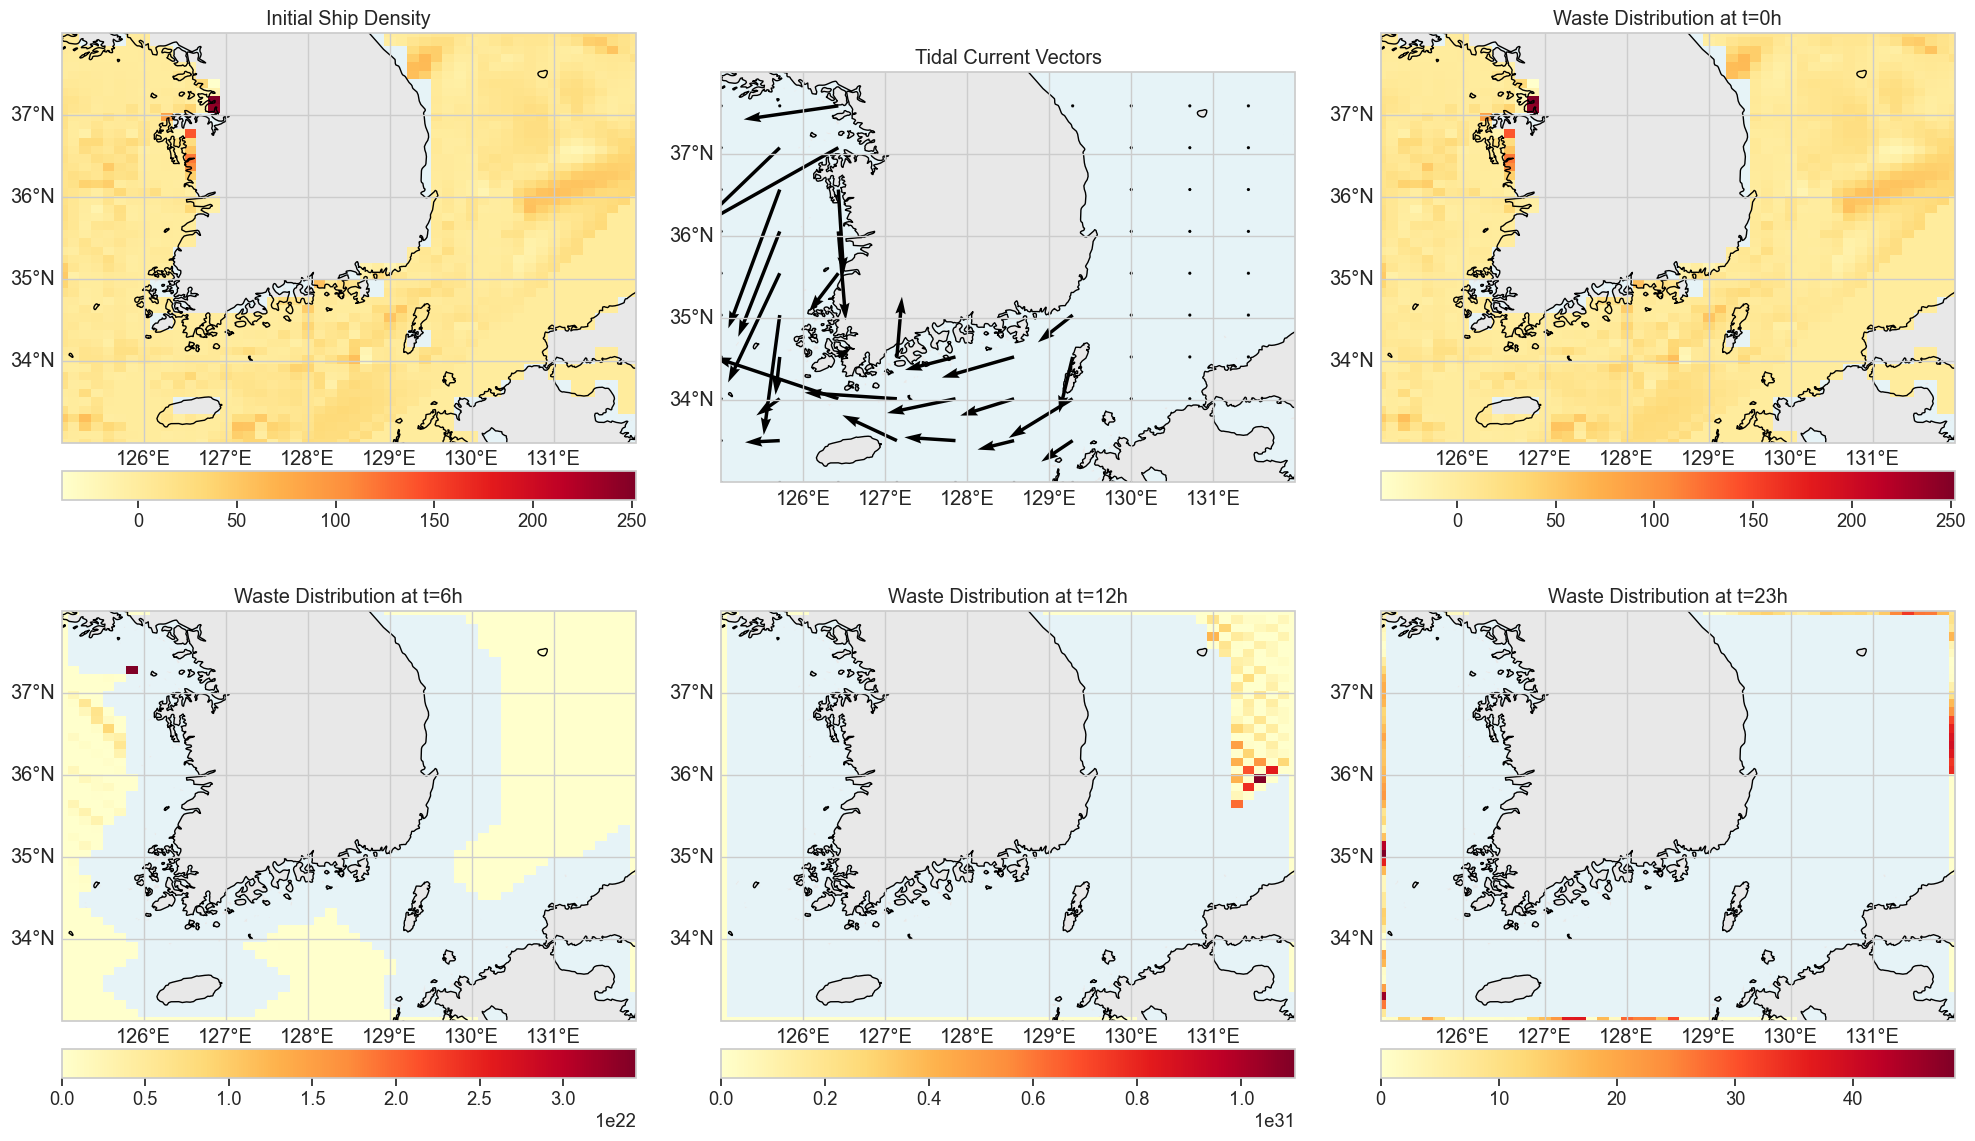

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
from scipy.interpolate import griddata
import shapely.geometry

def fetch_tidal_current_data(api_url):
    """KHOA API에서 조류 데이터 가져오기"""
    response = requests.get(api_url)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]
        
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)
        
        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)
        
        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None

def load_ship_density_data(file_path):
    """선박 밀집도 데이터 로드"""
    df_ship = pd.read_csv(file_path)
    df_ship["Latitude"] = df_ship["Latitude"].astype(float)
    df_ship["Longitude"] = df_ship["Longitude"].astype(float)
    df_ship["Density"] = df_ship["Density"].astype(float)
    return df_ship

def create_grid(df_ship, df_tidal, grid_size=50):  # 격자 크기 줄임
    """시뮬레이션을 위한 격자 생성"""
    # 전체 영역 범위 설정 (한국 전 해역)
    lon_min, lon_max = 125, 132  # 동해 포함
    lat_min, lat_max = 33, 38    # 남해-동해 포함
    
    # 격자점 생성
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    
    return lon_mesh, lat_mesh

def interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh):
    """데이터를 격자에 보간"""
    # 선박 밀집도 보간
    density = griddata(
        (df_ship['Longitude'], df_ship['Latitude']),
        df_ship['Density'],
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    # 해류 U, V 성분 보간
    angles = np.radians(90 - df_tidal["current_dir"])  # 북쪽이 0도
    U = df_tidal["current_speed"] * np.cos(angles)
    V = df_tidal["current_speed"] * np.sin(angles)
    
    U_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        U,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    V_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        V,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    return density, U_interp, V_interp

def create_ocean_mask(lon_mesh, lat_mesh):
    """육지를 제외한 해양 영역 마스크 생성 (최적화 버전)"""
    ocean_mask = np.ones_like(lon_mesh)
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m')  # 해상도 낮춤
    
    # 격자 간격으로 건너뛰며 계산
    step = 2
    for i in range(0, lon_mesh.shape[0], step):
        for j in range(0, lon_mesh.shape[1], step):
            point = shapely.geometry.Point(lon_mesh[i,j], lat_mesh[i,j])
            for geom in land.geometries():
                if point.within(geom):
                    ocean_mask[i:i+step, j:j+step] = np.nan
                    break
    
    return ocean_mask

def simulate_waste_movement(density, U_interp, V_interp, ocean_mask, dt=1, steps=24):
    """쓰레기 이동 시뮬레이션"""
    waste = density.copy() * ocean_mask  # 초기 쓰레기 분포
    waste_history = [waste.copy()]
    
    dx = 0.01  # 격자 간격 (위경도 단위)
    dy = 0.01
    
    for _ in range(steps):
        waste_new = waste.copy()
        
        # 이류 항 계산 (해류에 의한 이동)
        waste_new[1:-1, 1:-1] -= (
            (U_interp[1:-1, 1:-1] * 
             (waste[1:-1, 2:] - waste[1:-1, :-2]) / (2 * dx)) * dt
        )
        
        waste_new[1:-1, 1:-1] -= (
            (V_interp[1:-1, 1:-1] * 
             (waste[2:, 1:-1] - waste[:-2, 1:-1]) / (2 * dy)) * dt
        )
        
        # 확산 항 계산
        diffusion_coef = 0.01
        waste_new[1:-1, 1:-1] += diffusion_coef * (
            (waste[2:, 1:-1] + waste[:-2, 1:-1] + 
             waste[1:-1, 2:] + waste[1:-1, :-2] - 
             4 * waste[1:-1, 1:-1]) / (dx * dy)
        ) * dt
        
        # 해양 마스크 적용 및 음수 방지
        waste_new = waste_new * ocean_mask
        waste_new[waste_new < 0] = 0
        
        waste = waste_new
        waste_history.append(waste.copy())
    
    return waste_history

def plot_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history, ocean_mask):
    """시뮬레이션 결과 시각화"""
    sns.set_context("notebook", font_scale=1.2)
    fig = plt.figure(figsize=(20, 12))
    projection = ccrs.PlateCarree()
    
    def create_map_axes(position):
        ax = fig.add_subplot(position, projection=projection)
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_extent([125, 132, 33, 38], crs=projection)
        return ax
    
    # 선박 밀집도
    ax1 = create_map_axes(231)
    masked_density = density * ocean_mask
    im1 = ax1.pcolormesh(lon_mesh, lat_mesh, masked_density, 
                         shading='auto', cmap='YlOrRd',
                         transform=projection)
    ax1.set_title('Initial Ship Density')
    plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05)
    
    # 해류 벡터장
    ax2 = create_map_axes(232)
    skip = 5
    U_masked = U_interp * ocean_mask
    V_masked = V_interp * ocean_mask
    ax2.quiver(lon_mesh[::skip, ::skip], lat_mesh[::skip, ::skip],
               U_masked[::skip, ::skip], V_masked[::skip, ::skip],
               transform=projection)
    ax2.set_title('Tidal Current Vectors')
    
    # 시간별 쓰레기 분포
    times = [0, 6, 12, 23]
    positions = [233, 234, 235, 236]
    
    for t, pos in zip(times, positions):
        ax = create_map_axes(pos)
        im = ax.pcolormesh(lon_mesh, lat_mesh, waste_history[t],
                          shading='auto', cmap='YlOrRd',
                          transform=projection)
        ax.set_title(f'Waste Distribution at t={t}h')
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
    
    plt.tight_layout()
    plt.show()

def main():
    # API URL 및 데이터 경로 설정
    api_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    api_url += "?ServiceKey=c/JboSuOOn1VCop00VUC1w=="
    api_url += "&Date=20250220&Hour=01&Minute=00"
    api_url += "&MaxX=132&MinX=125&MaxY=38&MinY=33&ResultType=json"
    
    ship_density_file = "cleaned_sden_202502200100_grid3.csv"
    
    # 데이터 로드
    df_tidal = fetch_tidal_current_data(api_url)
    df_ship = load_ship_density_data(ship_density_file)
    
    if df_tidal is None:
        return
        
    # 격자 생성 및 데이터 보간
    lon_mesh, lat_mesh = create_grid(df_ship, df_tidal)
    density, U_interp, V_interp = interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh)
    
    # 해양 마스크 생성
    ocean_mask = create_ocean_mask(lon_mesh, lat_mesh)
    
    # 쓰레기 이동 시뮬레이션
    waste_history = simulate_waste_movement(density, U_interp, V_interp, ocean_mask)
    
    # 결과 시각화
    plot_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history, ocean_mask)

if __name__ == "__main__":
    main()

Simulating hour 1/4
Simulating hour 2/4
Simulating hour 3/4
Simulating hour 4/4
Available timesteps: 5


c:\Users\TAN\.conda\envs\marideb\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


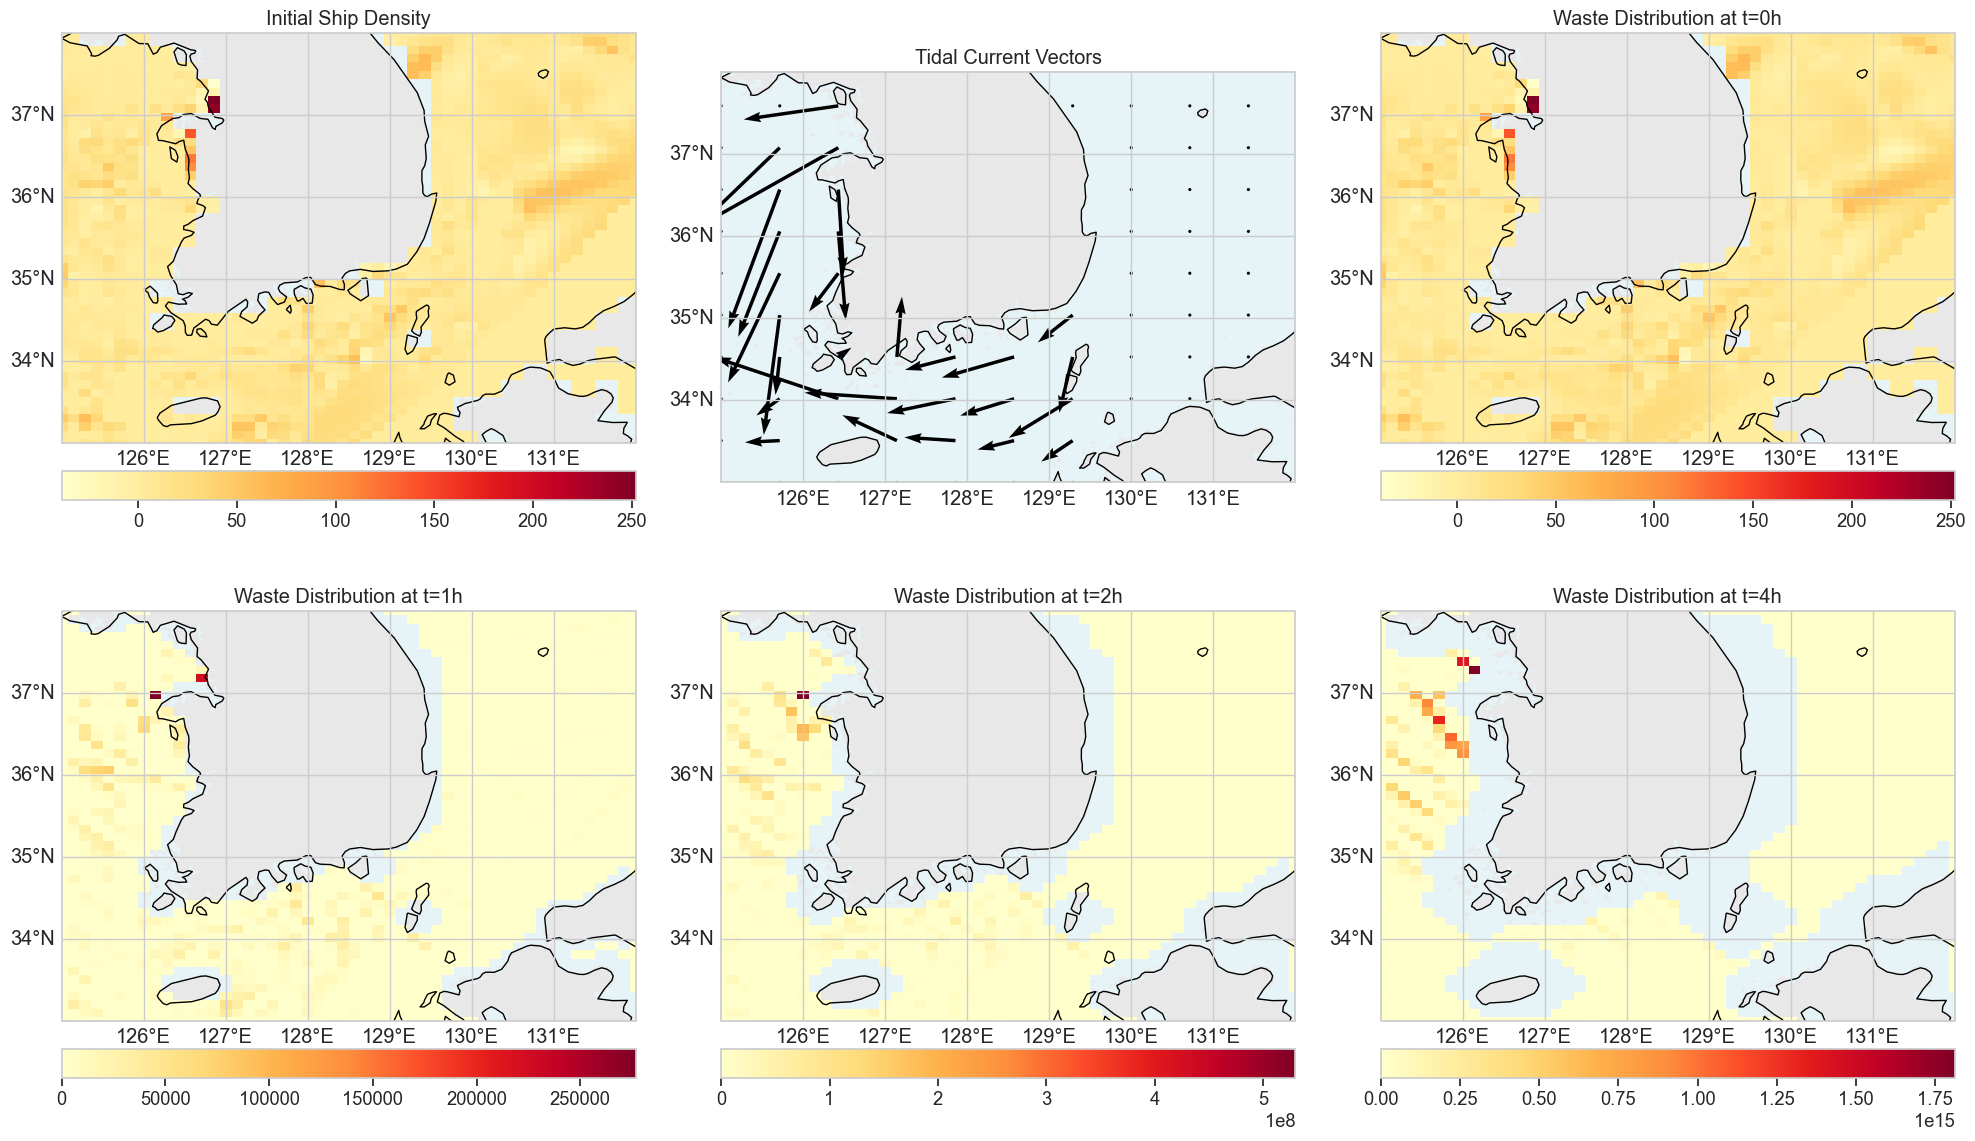

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
from scipy.interpolate import griddata
import shapely.geometry

def fetch_tidal_current_data(api_url):
    """KHOA API에서 조류 데이터 가져오기"""
    response = requests.get(api_url)
    
    if response.status_code == 200:
        json_data = response.json()
        tidal_data = json_data["result"]["data"]
        
        df_tidal = pd.DataFrame(tidal_data)
        df_tidal.rename(columns={"pre_lat": "Latitude", "pre_lon": "Longitude"}, inplace=True)
        
        # 숫자형 데이터 변환
        df_tidal["Latitude"] = df_tidal["Latitude"].astype(float)
        df_tidal["Longitude"] = df_tidal["Longitude"].astype(float)
        df_tidal["current_speed"] = df_tidal["current_speed"].astype(float)
        df_tidal["current_dir"] = df_tidal["current_dir"].astype(float)
        
        return df_tidal
    else:
        print(f"API 요청 실패! 상태 코드: {response.status_code}")
        return None

def load_ship_density_data(file_path):
    """선박 밀집도 데이터 로드"""
    df_ship = pd.read_csv(file_path)
    df_ship["Latitude"] = df_ship["Latitude"].astype(float)
    df_ship["Longitude"] = df_ship["Longitude"].astype(float)
    df_ship["Density"] = df_ship["Density"].astype(float)
    return df_ship

def create_grid(df_ship, df_tidal, grid_size=50):
    """시뮬레이션을 위한 격자 생성"""
    lon_min, lon_max = 125, 132  # 한국 전체 해역
    lat_min, lat_max = 33, 38
    
    lon_grid = np.linspace(lon_min, lon_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)
    
    return lon_mesh, lat_mesh

def interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh):
    """데이터를 격자에 보간"""
    density = griddata(
        (df_ship['Longitude'], df_ship['Latitude']),
        df_ship['Density'],
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    angles = np.radians(90 - df_tidal["current_dir"])
    U = df_tidal["current_speed"] * np.cos(angles)
    V = df_tidal["current_speed"] * np.sin(angles)
    
    U_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        U,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    V_interp = griddata(
        (df_tidal['Longitude'], df_tidal['Latitude']),
        V,
        (lon_mesh, lat_mesh),
        method='cubic',
        fill_value=0
    )
    
    return density, U_interp, V_interp

def create_ocean_mask(lon_mesh, lat_mesh):
    """육지를 제외한 해양 영역 마스크 생성"""
    ocean_mask = np.ones_like(lon_mesh)
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m')
    
    # 격자 간격으로 건너뛰며 계산
    step = 2
    for i in range(0, lon_mesh.shape[0], step):
        for j in range(0, lon_mesh.shape[1], step):
            point = shapely.geometry.Point(lon_mesh[i,j], lat_mesh[i,j])
            for geom in land.geometries():
                if point.within(geom):
                    ocean_mask[i:i+step, j:j+step] = np.nan
                    break
    
    return ocean_mask

def simulate_waste_movement(density, U_interp, V_interp, ocean_mask, dt=1, max_time=4):
    """쓰레기 이동 시뮬레이션"""
    waste = density.copy() * ocean_mask
    waste_history = [waste.copy()]
    steps = max_time + 1  # 0시간부터 4시간까지

    for step in range(max_time):
        print(f"Simulating hour {step+1}/{max_time}")
        waste_new = waste.copy()
        
        # 이류 항 계산
        dx = 0.01
        dy = 0.01
        
        waste_new[1:-1, 1:-1] -= (
            (U_interp[1:-1, 1:-1] * 
             (waste[1:-1, 2:] - waste[1:-1, :-2]) / (2 * dx)) * dt
        )
        
        waste_new[1:-1, 1:-1] -= (
            (V_interp[1:-1, 1:-1] * 
             (waste[2:, 1:-1] - waste[:-2, 1:-1]) / (2 * dy)) * dt
        )
        
        # 확산 항 계산
        diffusion_coef = 0.01
        waste_new[1:-1, 1:-1] += diffusion_coef * (
            (waste[2:, 1:-1] + waste[:-2, 1:-1] + 
             waste[1:-1, 2:] + waste[1:-1, :-2] - 
             4 * waste[1:-1, 1:-1]) / (dx * dy)
        ) * dt
        
        waste_new = waste_new * ocean_mask
        waste_new[waste_new < 0] = 0
        
        waste = waste_new
        waste_history.append(waste.copy())
    
    return waste_history

def plot_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history, ocean_mask):
    """시뮬레이션 결과 시각화"""
    print(f"Available timesteps: {len(waste_history)}")
    
    sns.set_context("notebook", font_scale=1.2)
    fig = plt.figure(figsize=(20, 12))
    projection = ccrs.PlateCarree()
    
    def create_map_axes(position):
        ax = fig.add_subplot(position, projection=projection)
        ax.coastlines(resolution='50m', color='black', linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.top_labels = False
        gl.right_labels = False
        ax.set_extent([125, 132, 33, 38], crs=projection)
        return ax
    
    # 선박 밀집도
    ax1 = create_map_axes(231)
    masked_density = density * ocean_mask
    im1 = ax1.pcolormesh(lon_mesh, lat_mesh, masked_density, 
                         shading='auto', cmap='YlOrRd',
                         transform=projection)
    ax1.set_title('Initial Ship Density')
    plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05)
    
    # 해류 벡터장
    ax2 = create_map_axes(232)
    skip = 5
    U_masked = U_interp * ocean_mask
    V_masked = V_interp * ocean_mask
    ax2.quiver(lon_mesh[::skip, ::skip], lat_mesh[::skip, ::skip],
               U_masked[::skip, ::skip], V_masked[::skip, ::skip],
               transform=projection)
    ax2.set_title('Tidal Current Vectors')
    
    # 시간별 쓰레기 분포
    times = [0, 1, 2, 4]  # 초기, 1시간 후, 2시간 후, 4시간 후
    positions = [233, 234, 235, 236]
    
    for t, pos in zip(times, positions):
        ax = create_map_axes(pos)
        im = ax.pcolormesh(lon_mesh, lat_mesh, waste_history[t],
                          shading='auto', cmap='YlOrRd',
                          transform=projection)
        ax.set_title(f'Waste Distribution at t={t}h')
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
    
    plt.tight_layout()
    plt.show()

def main():
    # API URL 및 데이터 경로 설정
    api_url = "http://www.khoa.go.kr/api/oceangrid/tidalCurrentArea/search.do"
    api_url += "?ServiceKey=c/JboSuOOn1VCop00VUC1w=="
    api_url += "&Date=20250220&Hour=01&Minute=00"
    api_url += "&MaxX=132&MinX=125&MaxY=38&MinY=33&ResultType=json"
    
    ship_density_file = "cleaned_sden_202502200100_grid3.csv"
    
    # 데이터 로드
    df_tidal = fetch_tidal_current_data(api_url)
    df_ship = load_ship_density_data(ship_density_file)
    
    if df_tidal is None:
        return
    
    # 격자 생성 및 데이터 보간
    lon_mesh, lat_mesh = create_grid(df_ship, df_tidal)
    density, U_interp, V_interp = interpolate_data(df_ship, df_tidal, lon_mesh, lat_mesh)
    
    # 해양 마스크 생성
    ocean_mask = create_ocean_mask(lon_mesh, lat_mesh)
    
    # 쓰레기 이동 시뮬레이션
    waste_history = simulate_waste_movement(density, U_interp, V_interp, ocean_mask)
    
    # 결과 시각화
    plot_results(lon_mesh, lat_mesh, density, U_interp, V_interp, waste_history, ocean_mask)

if __name__ == "__main__":
    main()